In [1]:
import pandas as pd
import numpy as np

random_df = pd.read_csv('random_tweets_processed.csv')
depressed_df = pd.read_csv('depressive_tweets_processed.csv')
random_df.tweet = random_df.tweet.astype(str)
depressed_df.tweet = depressed_df.tweet.astype(str)

np.random.seed(43)

In [2]:
from gensim.models import KeyedVectors
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [3]:
X_r = random_df['tweet'].tolist()
X_d = depressed_df['tweet'].tolist()

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 20000)
tokenizer.fit_on_texts(X_d + X_r)

In [5]:
sequence_d = tokenizer.texts_to_sequences(X_d)
sequence_r = tokenizer.texts_to_sequences(X_r)

In [6]:
data_d = pad_sequences(sequence_d, maxlen=100)
data_r = pad_sequences(sequence_r, maxlen=100)

In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 12635 unique tokens


In [8]:
nb_words = min(20000, len(word_index))

embedding_matrix = np.zeros((nb_words+1, 300))

for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < 20000:
        embedding_matrix[idx] = word2vec.word_vec(word)

In [9]:
d_rows = len(data_d)
r_rows = len(data_r)

labels_d = np.array([1] * d_rows)
labels_r = np.array([0] * r_rows)

perm_d = np.random.permutation(d_rows)
train_d_idx = perm_d[:int((0.7)*(d_rows))]
val_d_idx = perm_d[int((0.7)*(d_rows)) : int((0.85)*(d_rows))]
test_d_idx = perm_d[int((0.85)*(d_rows)):]

perm_r = np.random.permutation(r_rows)
train_r_idx = perm_r[:int((0.7)*(r_rows))]
val_r_idx = perm_r[int((0.7)*(r_rows)) : int((0.85)*(r_rows))]
test_r_idx = perm_r[int((0.85)*(r_rows)):]

data_train = np.concatenate((data_d[train_d_idx], data_r[train_r_idx]))
labels_train = np.concatenate((labels_d[train_d_idx], labels_r[train_r_idx]))
data_val = np.concatenate((data_d[val_d_idx], data_r[val_r_idx]))
labels_val = np.concatenate((labels_d[val_d_idx], labels_r[val_r_idx]))
data_test = np.concatenate((data_d[test_d_idx], data_r[test_r_idx]))
labels_test = np.concatenate((labels_d[test_d_idx], labels_r[test_r_idx]))

perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

In [10]:
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPooling1D
from keras.layers import Activation, MaxPooling1D, BatchNormalization, GRU, Bidirectional, SpatialDropout1D

### LSTM + CNN

In [11]:
model = Sequential()

model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix],
                   input_length=100, trainable=False))

model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))

model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.2))

model.add(LSTM(300))

model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [12]:
model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          3790800   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 64)           38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 300)               438000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [13]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=10, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/10
205/205 [==============================] - 21s 101ms/step - loss: 0.2014 - acc: 0.9261 - val_loss: 0.0901 - val_acc: 0.9743
Epoch 2/10
205/205 [==============================] - 21s 103ms/step - loss: 0.0572 - acc: 0.9823 - val_loss: 0.0553 - val_acc: 0.9850
Epoch 3/10
205/205 [==============================] - 22s 106ms/step - loss: 0.0386 - acc: 0.9879 - val_loss: 0.0655 - val_acc: 0.9829
Epoch 4/10
205/205 [==============================] - 22s 108ms/step - loss: 0.0352 - acc: 0.9902 - val_loss: 0.0638 - val_acc: 0.9872
Epoch 5/10
205/205 [==============================] - 22s 109ms/step - loss: 0.0272 - acc: 0.9917 - val_loss: 0.0598 - val_acc: 0.9864


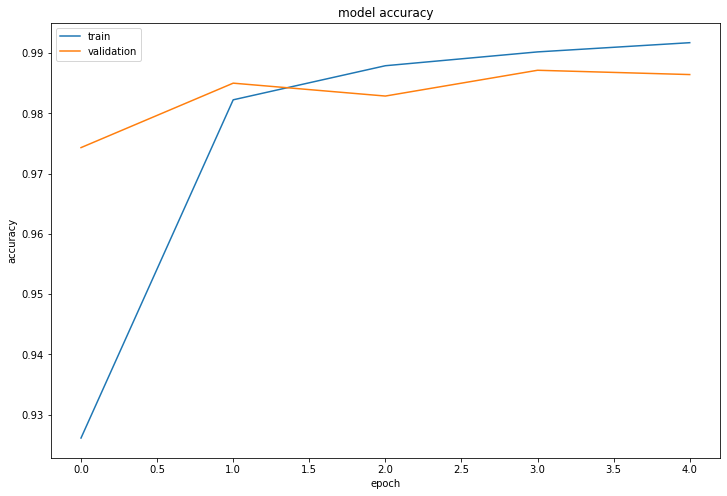

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

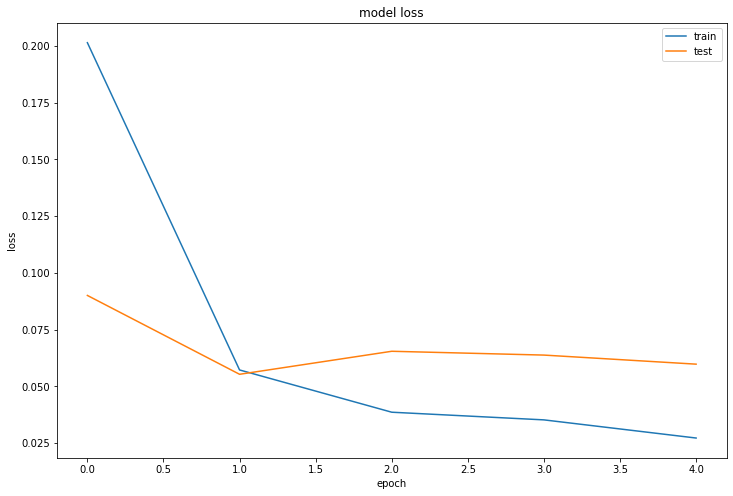

In [15]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [16]:
from sklearn.metrics import accuracy_score

labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.36%


In [17]:
from sklearn.metrics import  classification_report

print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1206
           1       0.98      0.90      0.94       195

    accuracy                           0.98      1401
   macro avg       0.98      0.95      0.96      1401
weighted avg       0.98      0.98      0.98      1401



### LSTM

In [18]:
model = Sequential()

model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix], 
                   input_length=100, trainable=False))
model.add(LSTM(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [19]:
model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3790800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 4,512,301
Trainable params: 721,501
Non-trainable params: 3,790,800
_________________________________________________________________
None


In [20]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=10, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/10
205/205 [==============================] - 57s 280ms/step - loss: 0.2185 - acc: 0.9247 - val_loss: 0.0813 - val_acc: 0.9736
Epoch 2/10
205/205 [==============================] - 61s 297ms/step - loss: 0.0597 - acc: 0.9821 - val_loss: 0.0610 - val_acc: 0.9815
Epoch 3/10
205/205 [==============================] - 59s 288ms/step - loss: 0.0501 - acc: 0.9855 - val_loss: 0.0623 - val_acc: 0.9822
Epoch 4/10
205/205 [==============================] - 61s 299ms/step - loss: 0.0508 - acc: 0.9841 - val_loss: 0.0696 - val_acc: 0.9800
Epoch 5/10
205/205 [==============================] - 59s 286ms/step - loss: 0.0332 - acc: 0.9891 - val_loss: 0.0593 - val_acc: 0.9843
Epoch 6/10
205/205 [==============================] - 61s 298ms/step - loss: 0.1470 - acc: 0.9576 - val_loss: 0.3834 - val_acc: 0.8638
Epoch 7/10
205/205 [==============================] - 63s 309ms/step - loss: 0.0868 - acc: 0.9705 - val_loss: 0.0558 - val_acc: 0.9857
Epoch 8/10
205/205 [==============================] - 6

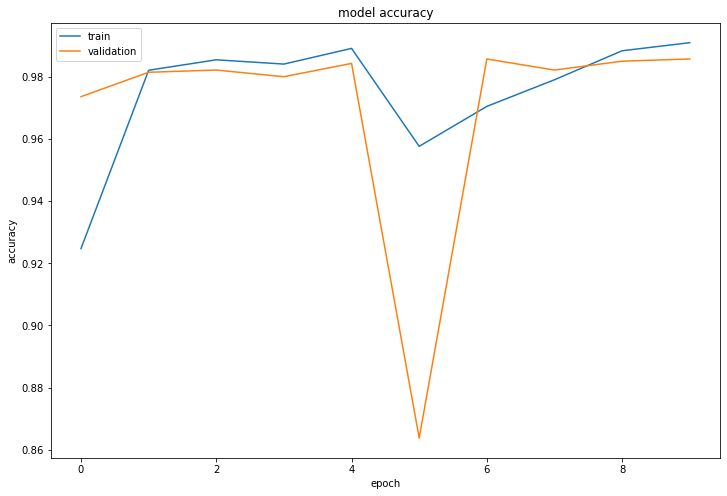

In [21]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

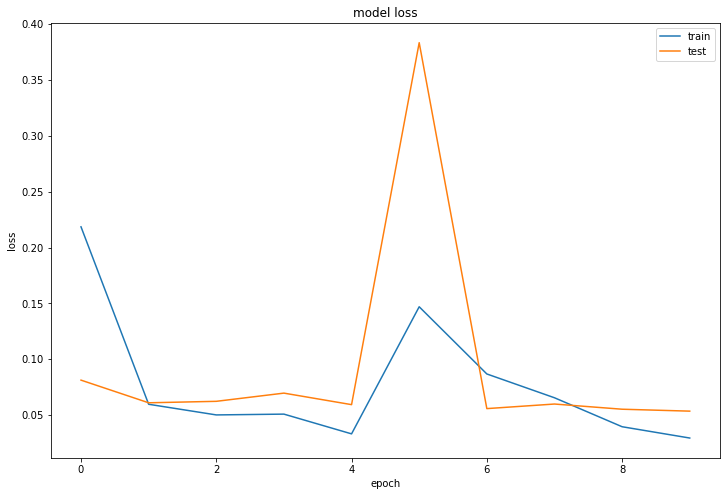

In [22]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [23]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.57%


In [24]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1206
           1       0.98      0.91      0.95       195

    accuracy                           0.99      1401
   macro avg       0.98      0.96      0.97      1401
weighted avg       0.99      0.99      0.99      1401



### CNN

In [25]:
model = Sequential()

model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix], 
                   input_length=100, trainable=False))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          3790800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 128)          192128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 3,984,229
Trainable params: 193,429
Non-trainable params: 3,790,800
_________________________________________________________________
None


In [27]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=10, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/10
205/205 [==============================] - 4s 18ms/step - loss: 0.1260 - acc: 0.9622 - val_loss: 0.0660 - val_acc: 0.9800
Epoch 2/10
205/205 [==============================] - 4s 18ms/step - loss: 0.0285 - acc: 0.9924 - val_loss: 0.0607 - val_acc: 0.9857
Epoch 3/10
205/205 [==============================] - 4s 19ms/step - loss: 0.0145 - acc: 0.9963 - val_loss: 0.0676 - val_acc: 0.9850
Epoch 4/10
205/205 [==============================] - 4s 18ms/step - loss: 0.0108 - acc: 0.9969 - val_loss: 0.0659 - val_acc: 0.9843
Epoch 5/10
205/205 [==============================] - 4s 18ms/step - loss: 0.0085 - acc: 0.9972 - val_loss: 0.0699 - val_acc: 0.9850


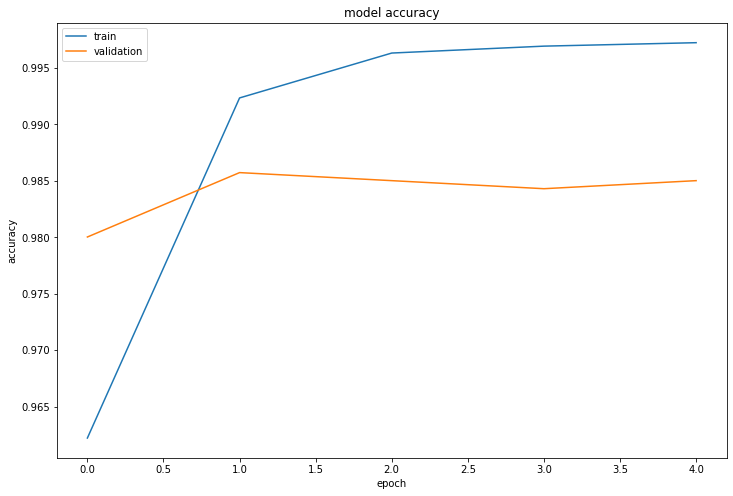

In [28]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

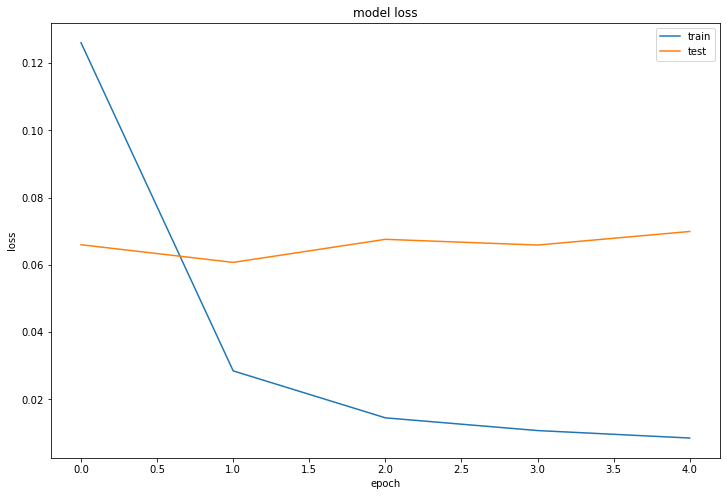

In [29]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [30]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.50%


In [31]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1206
           1       0.99      0.90      0.94       195

    accuracy                           0.99      1401
   macro avg       0.99      0.95      0.97      1401
weighted avg       0.99      0.99      0.98      1401



### GRU

In [32]:
model = Sequential()

model.add(Embedding(len(embedding_matrix), 300, weights=[embedding_matrix],
                   input_length=100, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(GRU(300)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [33]:
model.compile(loss='binary_crossentropy', optimizer = 'nadam', metrics=['acc'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          3790800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1083600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 601       
Total params: 4,875,001
Trainable params: 1,084,201
Non-trainable params: 3,790,800
_________________________________________________________________
None


In [34]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=3)

hist = model.fit(data_train, labels_train, \
        validation_data=(data_val, labels_val), \
        epochs=10, batch_size=32, shuffle=True, \
        callbacks = [early_stop])

Epoch 1/10
205/205 [==============================] - 97s 473ms/step - loss: 0.1512 - acc: 0.9483 - val_loss: 0.0677 - val_acc: 0.9786
Epoch 2/10
205/205 [==============================] - 101s 493ms/step - loss: 0.0540 - acc: 0.9841 - val_loss: 0.0638 - val_acc: 0.9800
Epoch 3/10
205/205 [==============================] - 110s 534ms/step - loss: 0.0424 - acc: 0.9881 - val_loss: 0.0546 - val_acc: 0.9857
Epoch 4/10
205/205 [==============================] - 105s 514ms/step - loss: 0.0363 - acc: 0.9896 - val_loss: 0.0527 - val_acc: 0.9864
Epoch 5/10
205/205 [==============================] - 103s 505ms/step - loss: 0.0277 - acc: 0.9908 - val_loss: 0.0647 - val_acc: 0.9836
Epoch 6/10
205/205 [==============================] - 108s 526ms/step - loss: 0.0269 - acc: 0.9927 - val_loss: 0.0676 - val_acc: 0.9857
Epoch 7/10
205/205 [==============================] - 105s 514ms/step - loss: 0.0235 - acc: 0.9925 - val_loss: 0.0756 - val_acc: 0.9836


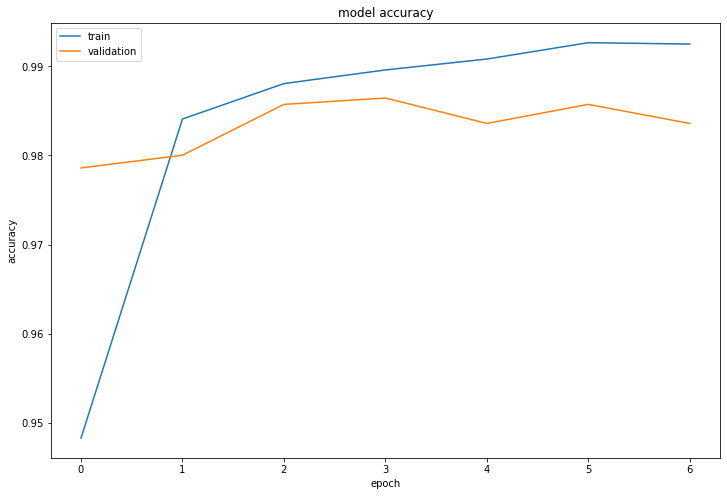

In [35]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

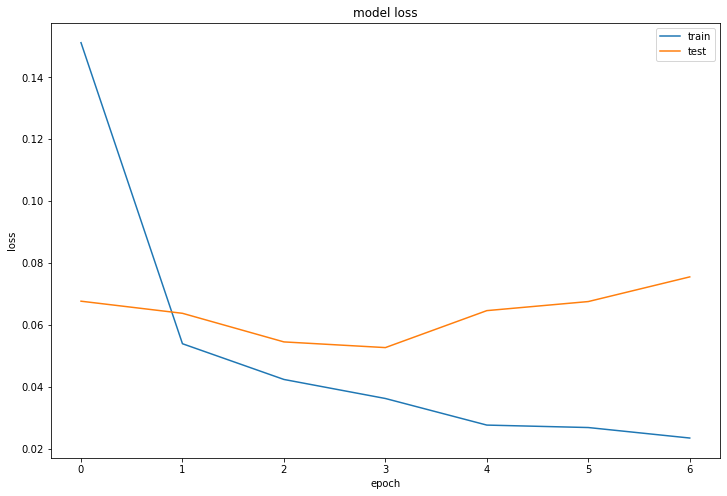

In [36]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [37]:
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 98.50%


In [38]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1206
           1       0.97      0.92      0.94       195

    accuracy                           0.99      1401
   macro avg       0.98      0.96      0.97      1401
weighted avg       0.98      0.99      0.98      1401



In [39]:
X_train = np.concatenate((data_train, data_val))
y_train = np.concatenate((labels_train, labels_val))

In [40]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter = 5000)
logreg.fit(X_train, y_train)
accuracy = logreg.score(data_test, labels_test)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 86.58%
